In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import requests
from collections import Counter

In [2]:
#spy=pd.read_csv("data/SPY_weekly.csv")
#spy.rename(columns={'Adj Close':"adj_close"}, inplace=True)
#spy=spy.astype({'Date': 'datetime64'})

In [3]:
ticker='EA'
d={'function': 'TIME_SERIES_WEEKLY_ADJUSTED','apikey':"YEUC2DL0F7KC43PB",'symbol':ticker}
response = requests.get(
        'https://www.alphavantage.co/query',
        params=d,
        )

In [4]:
#open #high #low #close #adjusted close  #volume #dividend amount
spy=[[],[],[],[],[],[],[]]
for key, val in response.json()['Weekly Adjusted Time Series'].items():
    spy[0].append(float(val['1. open']))
    spy[1].append(float(val['2. high']))
    spy[2].append(float(val['3. low']))
    spy[3].append(float(val['4. close']))
    spy[4].append(float(val['5. adjusted close']))
    spy[5].append(float(val['6. volume']))
    spy[6].append(float(val['7. dividend amount']))

In [5]:
spy=pd.DataFrame({'Date':list(response.json()['Weekly Adjusted Time Series'].keys()),
                 'open':spy[0],
                  'high':spy[1],
                  'low':spy[2],
                  'close':spy[3],
                  'adj_close':spy[4],
                  'volume':spy[5],
                  'dividend':spy[6],
                 })
spy=spy.astype({'Date': 'datetime64'})


In [6]:
spy=spy.sort_values(by='Date')

In [7]:
spy.tail()

Date    open    high       low   close  adj_close      volume  \
4 2020-03-20   89.19   98.20   85.6900   86.94      86.94  32363789.0   
3 2020-03-27   89.73  103.10   88.4272   95.37      95.37  29191179.0   
2 2020-04-03   96.77  104.35   96.1700  102.83     102.83  19049244.0   
1 2020-04-09  105.39  109.38  100.1100  105.80     105.80  16693575.0   
0 2020-04-17  105.65  118.69  104.6500  115.15     115.15  17442813.0   

   dividend  
4       0.0  
3       0.0  
2       0.0  
1       0.0  
0       0.0

In [8]:
def return_percentile(x,window,t='latest',val=0):
    if t=='latest':
        x=x/x.shift(window)-1
        x=x.dropna().values
        val=x[-1]
        return np.round(100*(np.where(np.sort(x)==val)[0][0]/len(x)),2),val
    
    x=x/x.shift(window)-1
    x=x.dropna()
    return np.nanpercentile(x,val)

def get_percentile(x, t='latest',val=0):
    if t=='latest':
        x=x.dropna().values
        val=x[-1]
        return np.round(100*(np.where(np.sort(x)==val)[0][0]/len(x)),2),val
    else:
        return  np.nanpercentile(np.sort(x),val)
        

### Returns

In [9]:
return_percentile(spy.adj_close,window=3)# 3 weeks of trading

(98.46, 0.20740274719513474)

In [10]:
return_percentile(spy.adj_close,window=1,t='val',val=5)

-0.07669380215244846

In [11]:
ret=(spy.adj_close/spy.adj_close.shift(1)-1).dropna()
pos=[]
for idx, r in enumerate(np.where(ret<-0.038,1,0)):
    if r==1:
        pos.append(idx)
l=[]
for i in range(1,len(pos)):
    l.append(pos[i]-np.roll(np.asarray(pos),1)[i])        

In [12]:
len(ret)-pos[-1]-1 # subtracting to adjust for indices 

4

In [13]:
#Counter(l)

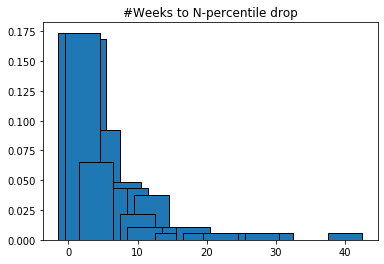

In [14]:
labels, values = zip(*Counter(l).items())
width = 5
plt.bar(labels, values/np.sum(values), width ,linewidth=1, edgecolor='black');
plt.title("#Weeks to N-percentile drop");

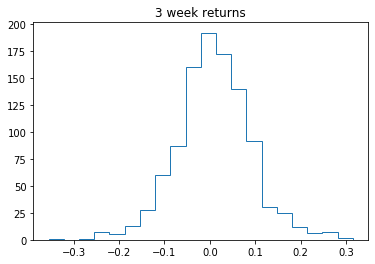

In [15]:
N=3
plt.hist((spy.adj_close/spy.adj_close.shift(N)-1).dropna(), bins=20, histtype='step')
plt.title('{} week returns'.format(N));

### STD

In [16]:
get_percentile(spy.adj_close.rolling(4).apply(np.std, raw=False))

(99.42, 7.087447971590339)

In [17]:
get_percentile(spy.adj_close.rolling(4).apply(np.std, raw=False),t='val',val=90)

2.704706002597016

/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


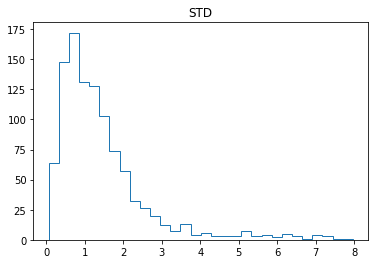

In [18]:
plt.hist(spy.adj_close.rolling(4).apply(np.std, raw=False), bins=30, histtype='step');
plt.title("STD");

### STO

In [19]:
d={'function': 'STOCH','apikey':"YEUC2DL0F7KC43PB",'symbol':ticker,'interval':'weekly','fastkperiod':16 }
response = requests.get(
        'https://www.alphavantage.co/query',
        params=d,
        )

In [20]:
slowk=[]
slowd=[]
for key, val in response.json()['Technical Analysis: STOCH'].items():
    slowk.append(float(val['SlowK']))
    slowd.append(float(val['SlowD']))

sto=pd.DataFrame({'Date':list(response.json()['Technical Analysis: STOCH'].keys()),
                 'k':slowk,
                  'd':slowd
                 })
sto=sto.astype({'Date': 'datetime64'})
sto['sto_diff']=sto['k']-sto['d']

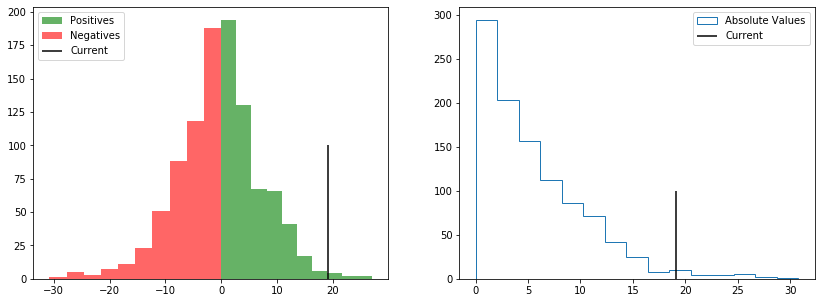

In [21]:
fig, ax = plt.subplots(1,2, figsize=(14,5))
ax[0].hist(sto.sto_diff[sto.sto_diff>=0], bins=10, alpha=0.6, color='g' ,label='Positives')
ax[0].hist(sto.sto_diff[sto.sto_diff<=0], bins=10, alpha=0.6, color='r' ,label='Negatives')
ax[0].vlines(sto.sto_diff[1],0,100 ,label='Current', color='black')
ax[0].legend(loc='upper left');

ax[1].hist(np.abs(sto.sto_diff), bins=15, histtype='step', label='Absolute Values');
ax[1].vlines(np.abs(sto.sto_diff[1]),0,100 ,label='Current')
ax[1].legend();

In [22]:
sto=sto.sort_values(by='Date')

In [23]:
get_percentile(sto.sto_diff)

(99.41, 19.643000000000008)

In [24]:
get_percentile(sto.sto_diff, t='val', val=10)

-9.101929999999996

In [25]:
# Diff probably helps more on the downside
get_percentile(sto.sto_diff[sto.sto_diff<=0],t='val',val=10)

-12.40616

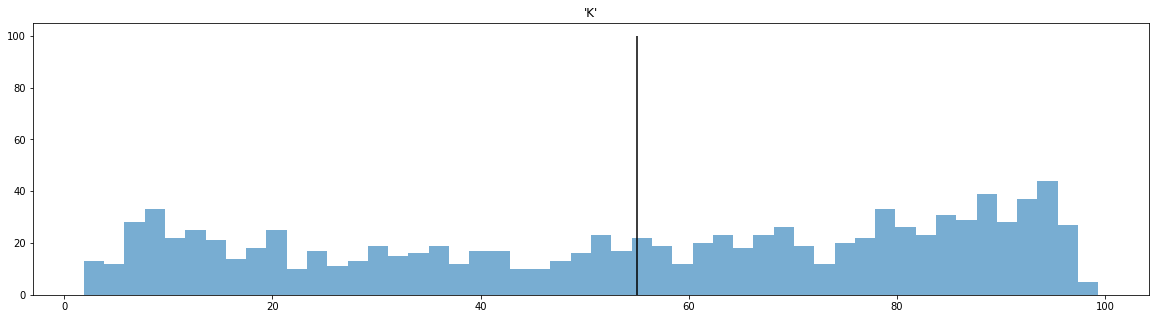

In [26]:
plt.figure(figsize=(20,5))
plt.title("'K'")
plt.vlines(sto.k[1],0,100)
plt.hist(sto.k, bins=50, alpha=0.6);


In [27]:
N=3
k_change=(sto.sort_values(by='Date').k/sto.sort_values(by='Date').k.shift(N)-1).dropna()

In [28]:
get_percentile(k_change)

(98.33, 2.712245094023836)

In [29]:
spy=spy.merge(sto,left_on='Date',right_on='Date',how='left')

In [30]:
spy['future_ret']=spy.adj_close.shift(-2)/spy.adj_close-1

In [40]:
vals=[[],[],[]]
upper_cut=20
lower_cut=17
for index, row in spy.dropna().iterrows():
    if row.sto_diff<=upper_cut and row.sto_diff>=lower_cut:
        vals[0].append(row.Date)
        vals[1].append(row.sto_diff)
        vals[2].append(row.future_ret)

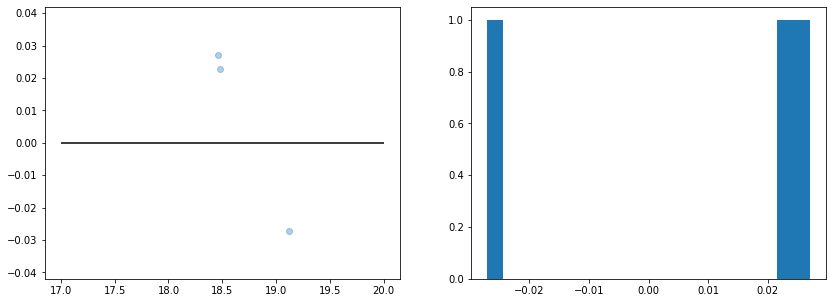

In [41]:
fig, ax = plt.subplots(1,2, figsize=(14,5))
ax[0].scatter(vals[1],vals[2], alpha=0.35)
ax[0].hlines(0,lower_cut,upper_cut);

ax[1].hist(vals[2], bins=20);

In [43]:
np.sum([np.asarray(vals[2])>=-0.05])/len(vals[2]), len(vals[2])

(1.0, 3)

### MACD

In [34]:
macd=spy.adj_close.ewm(span=12,min_periods=0,adjust=True,ignore_na=True).mean()-spy.adj_close.ewm(span=26,min_periods=0,adjust=True,ignore_na=True).mean()
signal=macd.ewm(span=12,min_periods=0,adjust=True,ignore_na=True).mean()
macd_hist=macd-signal

In [35]:
spy['macd']=macd
spy['macd_hist']=macd_hist

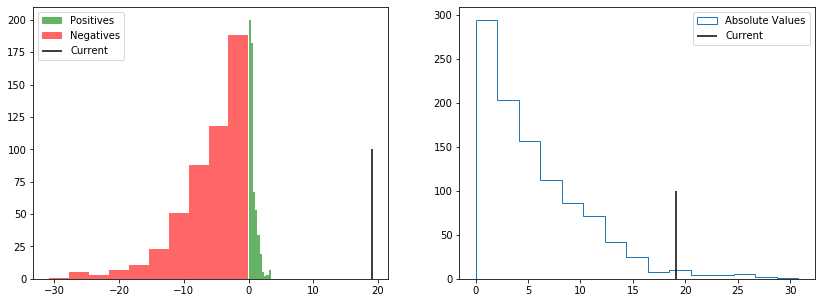

In [36]:
fig, ax = plt.subplots(1,2, figsize=(14,5))
ax[0].hist(macd_hist[macd_hist>=0], bins=10, alpha=0.6, color='g' ,label='Positives')
ax[0].hist(sto.sto_diff[sto.sto_diff<=0], bins=10, alpha=0.6, color='r' ,label='Negatives')
ax[0].vlines(sto.sto_diff[1],0,100 ,label='Current', color='black')
ax[0].legend(loc='upper left');

ax[1].hist(np.abs(sto.sto_diff), bins=15, histtype='step', label='Absolute Values');
ax[1].vlines(np.abs(sto.sto_diff[1]),0,100 ,label='Current')
ax[1].legend();

In [37]:
get_percentile(macd_hist)

(35.19, -0.19914916771437863)

### 20/50

In [38]:
spy

Date    open    high       low   close  adj_close      volume  \
0    2000-04-28   57.50   64.25   50.7500   60.50    15.1250   8271000.0   
1    2000-05-05   60.00   65.63   49.0000   61.69    15.4225  13126800.0   
2    2000-05-12   59.63   67.88   54.0000   60.38    15.0950   7444600.0   
3    2000-05-19   60.56   67.00   57.9400   57.94    14.4850   4914300.0   
4    2000-05-26   58.25   62.88   50.1900   58.00    14.5000   5599900.0   
...         ...     ...     ...       ...     ...        ...         ...   
1038 2020-03-20   89.19   98.20   85.6900   86.94    86.9400  32363789.0   
1039 2020-03-27   89.73  103.10   88.4272   95.37    95.3700  29191179.0   
1040 2020-04-03   96.77  104.35   96.1700  102.83   102.8300  19049244.0   
1041 2020-04-09  105.39  109.38  100.1100  105.80   105.8000  16693575.0   
1042 2020-04-17  105.65  118.69  104.6500  115.15   115.1500  17442813.0   

      dividend        k        d  sto_diff  future_ret      macd  macd_hist  
0          0.0      NaN      NaN       NaN   -0.001983  0.000000   0.000000  
1          0.0      NaN      NaN       NaN   -0.060788  0.006675   0.003059  
2          0.0      NaN      NaN       NaN   -0.039417 -0.001651  -0.003211  
3          0.0      NaN      NaN       NaN    0.237314 -0.027421  -0.019833  
4          0.0      NaN      NaN       NaN    0.153103 -0.040250  -0.023788  
...        ...      ...      ...       ...         ...       ...        ...  
1038       0.0  29.8084  41.2224  -11.4140    0.182770  0.193917  -2.191296  
1039       0.0  19.7769  29.5779   -9.8010    0.109364 -0.376830  -2.337114  
1040       0.0  32.8997  27.4950    5.4047    0.119809 -0.224602  -1.848750  
1041       0.0  55.0047  35.8938   19.1109         NaN  0.134147  -1.260770  
1042       0.0  73.4167  53.7737   19.6430         NaN  1.159558  -0.199149  

[1043 rows x 14 columns]

In [39]:
spy.adj_close.rolling(20).apply(np.mean, raw=False)

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
1038    104.4485
1039    104.3035
1040    104.5680
1041    104.8985
1042    105.6055
Name: adj_close, Length: 1043, dtype: float64